# Network Notebook

_This notebook is dedicated towards network creation, extraction, analysis and visualizations. This means that all network statistics, cleaning and experimentation lives in this notebook._


## Structure

_The notebook contains the different WikiPage networks, including analyses and visualisations. Thus, each network will have the following structure:_

1. Network creation
2. Network visualization
3. Network degree analysis
4. Other analyses

_The networks will be saved and fetched again after creation and before analyses. This way, if you want to play around with the networks, you don't have to create them again. Simply run the imports and the preparation section and skip ahead to the chapter you want._

**Some imports**:

In [163]:
import re
import networkx as nx
import pandas as pd
import numpy as np
import os
from collections import Counter
import pickle
from fa2 import ForceAtlas2
import matplotlib.pyplot as plt
import random
import seaborn as sns
import collections
import operator
%matplotlib inline

---

## Preparation - Accessing the Wiki files

_We'll start by accessing the dataframe of the cleaned WikiPages:_

In [94]:
# Defining home directory

hd = os.getcwd()
wiki_dir = "/".join(hd.split("/")[:-1]) + "/Wikis/"

# Fetching the dataframe

with open(wiki_dir + 'dataframes/cleaned_wiki_df.pkl', 'rb') as f:
    df_wiki = pickle.load(f)
    
df_wiki.head(2)

,wiki,book,alternative_wiki,text,links,house,type,blood,job,family,loyalties
0,Tufty,1,None,{{Pet individual infobox\n|image = \n|name = T...,"[Harry Potter, Mr Tibbles, Dudley Dursley, Ara...",None,Pet,Unknown,None,None,None
1,Mirror of Erised,1,None,{{Spoiler|PAS|WU}}\n{{Object infobox\n|name = ...,"[Argus Filch, Percival Dumbledore, Ronald Weas...",None,Object,Unknown,None,None,None


## Preparation - Defining functions and objects for visualizations


In [95]:
# Getting the ForceAtlas algorithm configuration ready

forceatlas2 = ForceAtlas2(
    # Behavior alternatives
    outboundAttractionDistribution = False, # Dissuade hubs
    edgeWeightInfluence=1,
    
    # Performance
    jitterTolerance=0.2, # Tolerance
    barnesHutOptimize=True,
    barnesHutTheta=0.6,
    
    # Tuning
    scalingRatio=5,
    strongGravityMode=True,
    gravity=1.0,
    
    # Log
    verbose=False
)

In [96]:
# Setting random seed for visualisation:

random.seed(15)

In [97]:
# For plotting in- and out-degree distributions. 

def display_histogram_and_loglog_distributions(G_type, print_str, title, bins):
    # Function that displays histogram and log-log of network side-by-side.
    # Takes in network type, print string, title, and number of bins for histogram
    # Typically gets (G.in_degree() or G.out_degree())
    
    degs = [deg for (node, deg) in G_type]
    hist, bin_edges = np.histogram(degs, bins=bins)
    degree_sequence = sorted([d for n, d in G_type], reverse=True)
    degreeCount = Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())

    fig, axs = plt.subplots(1, 2,figsize=(15,5)) # Side-by-side comparison
    fig.suptitle(title, size=18)
    
    axs[0].hist(degs, bin_edges) # Histogram plot
    axs[0].set(ylabel='Frequency', xlabel='Degree')
    axs[0].set_title('Histogram of the {} distribution'.format(print_str)) # Setting a dynamic title    
    axs[1].loglog(bin_edges[:-1], hist, 'bo', markersize=4) # Log-log plot
    axs[1].set_title('Log-log of the {} distribution'.format(print_str))
    axs[1].set(ylabel='Frequency', xlabel='Degree');
    
    plt.show()

In [98]:
def make_scatter_plots(G, with_percentiles = False, equalize_y_axis = False):
    # A function that makes side-by-side scatterplots of in-degree and out-degree distributions
    # Takes in Network and two booleans, self-explanatory
    
    node_indices = [i for i in range(len(G.nodes))] # indices
    nodes = [node for node in G.nodes] # all nodes in network

    #random.shuffle(nodes) # randomising the list for ordering

    in_degrees = [G.in_degree(node) for node in nodes] # All in-degree values
    out_degrees = [G.out_degree(node) for node in nodes] # All out-degree values
    
    all_degrees = in_degrees + out_degrees # All degrees to find max
    
    y_axis_max = max(all_degrees) # For y axis equalization
    
    fig, axs = plt.subplots(1, 2,figsize=(15,5)) 
    
    axs[0].scatter(node_indices, in_degrees, s=2) # In-degree scatter
    axs[0].set_xlabel('Network nodes (no particular order)')
    axs[0].set_ylabel('In degree')
    axs[0].set_title('In-degree scatter plot of the network')
    if(equalize_y_axis):
        axs[0].set_ylim(0, y_axis_max)
    
    axs[1].scatter(node_indices, out_degrees, s=2) # Out-degree scatter
    axs[1].set_xlabel('Network nodes (no particular order)')
    axs[1].set_ylabel('Out degree')
    axs[1].set_title('Out-degree scatter plot of the network')
    if(equalize_y_axis):
        axs[1].set_ylim(0, y_axis_max)

    if with_percentiles:
        # If percentile lines were requested
        
        percentiles = [95, 99, 99.7] # Defining three high percentiles to explore

        colours = ["#264653", "#e9c46a", "#e76f51"] # And their colours
        
        # Drawing line for each percentile on each graph
        for i in range(len(percentiles)):    
            axs[0].axhline(y=np.percentile(in_degrees, percentiles[i]), c=colours[i], xmin=0, xmax=1, alpha=0.9, label=str(percentiles[i])+"th pct")
            axs[1].axhline(y=np.percentile(out_degrees, percentiles[i]), c=colours[i], xmin=0, xmax=1, alpha=0.9, label=str(percentiles[i])+"th pct")
            axs[0].legend()
            axs[1].legend()

    return axs

In [99]:
def plot_scatter_with_labels_over_percentile(degs, print_str, title, percentile):
    fig=plt.figure(figsize=(8,5))
    ax=fig.add_axes([0,0,1,1])
    ax.scatter(node_indices, degs, s=[degree / 25 for degree in degs], c=degs, cmap="Blues") # Size map included
    ax.set_xlabel('Network nodes (random order)')
    ax.set_ylabel(print_str)
    #ax.set_ylabel('In degree')
    ax.set_title(title)
    #ax.set_title('In-degree scatter plot of the network (over 99.7th percentile)')

    # Adding the horizontal line for the 99.7th percentile
    plt.axhline(y=np.percentile(degs, percentile), xmin=0, xmax=1, alpha=0.7, label="{}th pct".format(percentile))   

    # And annotating the top degrees
    for n in range(len(degs)):
        if degs[n] > np.percentile(degs, percentile):
            plt.text(n+10, degs[n], nodes[n], fontsize=9)
    
    plt.legend()        
    plt.show()

---

# Unweighted Wiki Digraph

### - The Basic network we'll work with!


---

### 1. (Unweighted Wiki Digraph) Network creation
_We'll start by adding the nodes from the Wiki data:_

In [100]:
DG = nx.DiGraph()

# Add all the edges to the graph
for idx, row in df_wiki.iterrows():
    DG.add_node(row.wiki, # node name
                book_nr = row.book, 
                house = row.house, 
                node_type = row.type, 
                links = row.links, 
                wiki_text = row.text,
                job = row.job,
                blood = row.blood,
                family = row.family,
                loyalties = row.loyalties
               )
        
print("Added {} nodes. Size of network: {}".format(len(df_wiki), len(DG)))  

Added 788 nodes. Size of network: 788


_And then adding the edges:_

In [101]:
for idx, row in df_wiki[pd.notna(df_wiki.links)].iterrows():
    for link in row['links']:
        if link in DG: # If other entity is in the network
            DG.add_edge(row.wiki, link)
            
print("{} edges in network.".format(len(DG.edges)))

12386 edges in network.


_As this is the whole WikiPage network, no cleaning will be done here. We'll save it:_

In [102]:
# Creating a new folder to store the dataframe and switching to it:
if not os.path.exists("networks"):
    os.mkdir("networks")

# And saving the network:
with open(hd + '/networks/wiki_network_all_wikis.pkl', 'wb') as f:
    pickle.dump(DG, f)

---

### 2. (Unweighted Wiki Digraph) Network visualization

In [166]:
# Fetching the network that was created above

with open('networks/wiki_network_all_wikis.pkl', 'rb') as f:
    G = pickle.load(f)
    
print("Loaded network of type {}, containing {} nodes and {} edges.".format(type(G), len(G), len(G.edges)))

Loaded network of type <class 'networkx.classes.digraph.DiGraph'>, containing 788 nodes and 12386 edges.


In [105]:
# Getting positions for the network nodes

positions = forceatlas2.forceatlas2_networkx_layout(G, 
                                                    pos=None, 
                                                    iterations=2000);

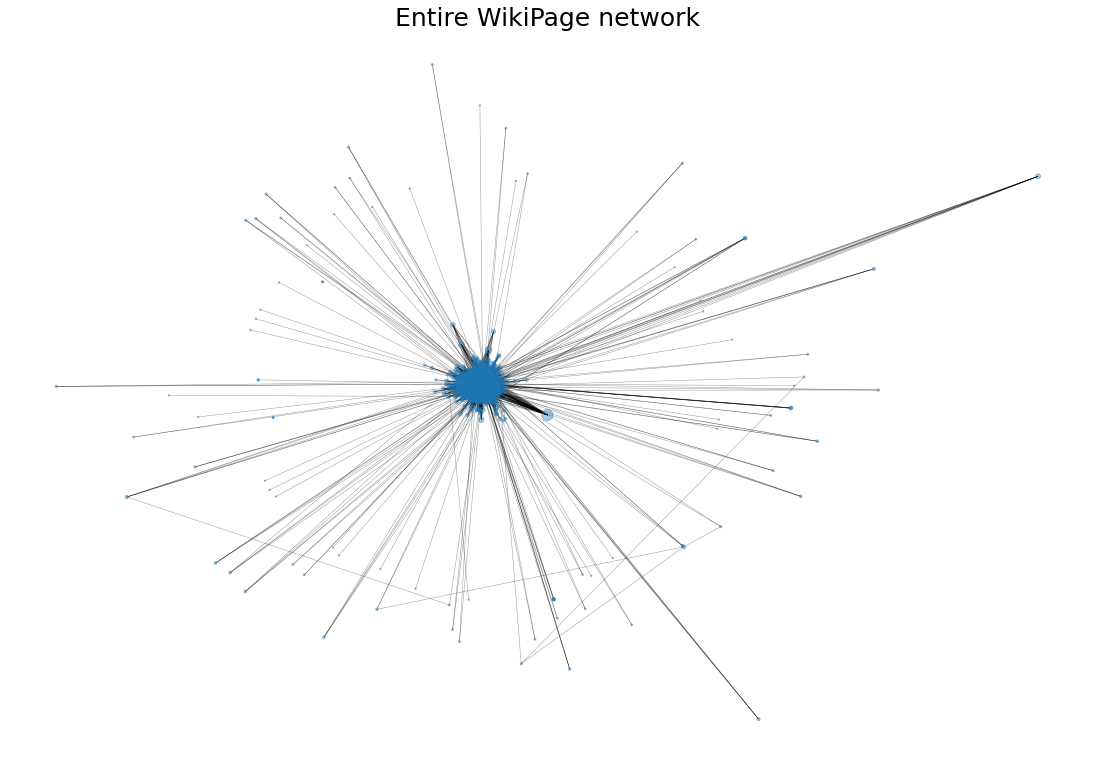

In [108]:
# Determining node sizes: 
node_sizes = [val*1500 for val in nx.degree_centrality(G).values()] 

# And we're ready to visualise:

plt.figure(figsize=(15,10))

nx.draw(nx.to_undirected(G), 
        positions, 
        with_labels = False, 
        node_size = node_sizes, 
        width=0.5, 
        alpha=0.4);

plt.title("Entire WikiPage network", fontsize=25, ha='center')
plt.show()

**The entire WikiNetwork is clearly very sparse and the visualization is not meaningful at all. The network clearly needs work before anything meaningful can be interpreted visually.**

---

### 3. (Unweighted Wiki Digraph) Network degree analysis
_In spite of the network not being easily visualised, we should analyse its degree distributions and so on:_

In [107]:
# Basic information on the Graph

print(nx.info(G))

Name: 
Type: DiGraph
Number of nodes: 788
Number of edges: 12386
Average in degree:  15.7183
Average out degree:  15.7183


**Plotting the in-degree and out-degree distributions:**

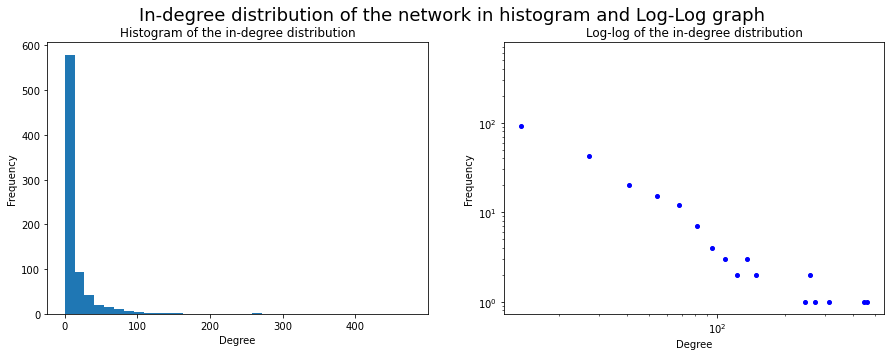

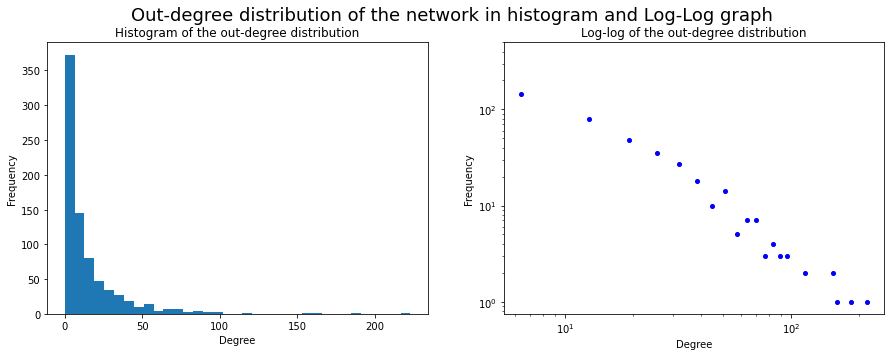

In [109]:
# Calling the predefined distribution visualisation functions

display_histogram_and_loglog_distributions(G_type=G.in_degree(), #Plotting the in-degree distribution
                                           bins=35, 
                                           print_str="in-degree", 
                                           title="In-degree distribution of the network in histogram and Log-Log graph")

display_histogram_and_loglog_distributions(G_type=G.out_degree(), # Plotting the out-degree distribution
                                           bins=35, 
                                           print_str="out-degree", 
                                           title="Out-degree distribution of the network in histogram and Log-Log graph")


_The total WikiPage network seems to show scale-free properties. It's very frequent to have little to no in-degrees, but the scale of in-degree distributions stretches fairly high. The out-degree distributions are more evenly distributed, with a few extremes as well._

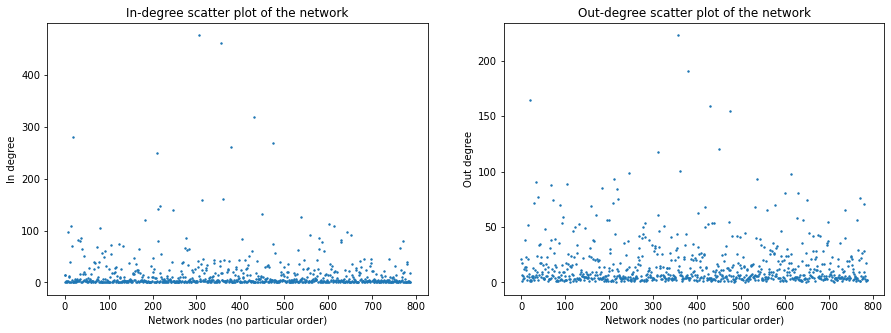

In [62]:
# Exploring the degree distributions through scatterplots

axs = make_scatter_plots(G)
plt.show()

_These two distributions are quite different, to show this, let's equalize the y-axes and show the high percentiles as lines:_

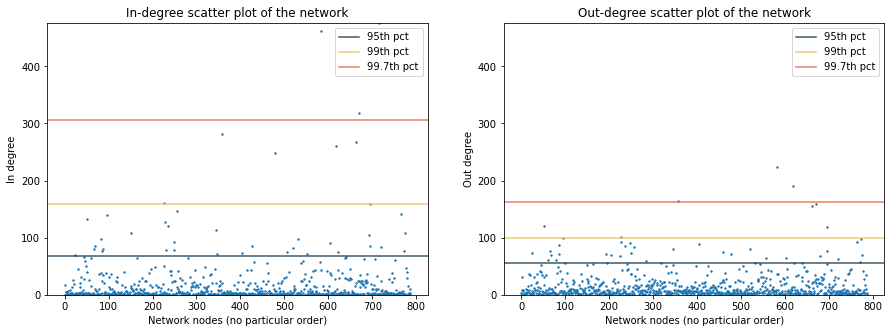

In [83]:
# Finding high percentiles in the degree distributions

axs = make_scatter_plots(G, 
                         with_percentiles = True, 
                         equalize_y_axis = True)

plt.show()

_Clearly, the in-degrees go a lot higher, although we've seen that more nodes have a very low in-degree than an out-degree. This further indicates that the network has hubs. Let's explore which nodes are so high in in-degrees:_

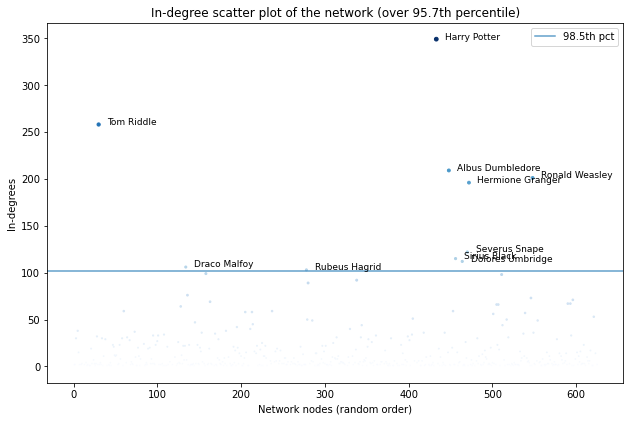

In [40]:
# Investigation of highest in-degree nodes: 

nodes = [node for node in G.nodes] # for this we need all nodes in network
node_indices = [i for i in range(len(G.nodes))] # indices

random.shuffle(nodes) # randomising the list for ordering (with same seed)

in_degrees = [G.in_degree(node) for node in nodes] # All in-degree values
out_degrees = [G.out_degree(node) for node in nodes] # All out-degree values

plot_scatter_with_labels_over_percentile(in_degrees, 
                                         "In-degrees", # Axis string
                                         "In-degree scatter plot of the network (over 98.5th percentile)", # Plot title 
                                         98.5 # percentile
                                        )

plt.show()

_This makes a lot of sense. But as we know - this network contains all the WikiPages from the Fandom page. So Harry Potter is not the most referenced page, Wizardkind is. Similarly, the British Ministry of Magic is ranked quite highly here. Aside from this, beloved characters from the books and films are displayed._

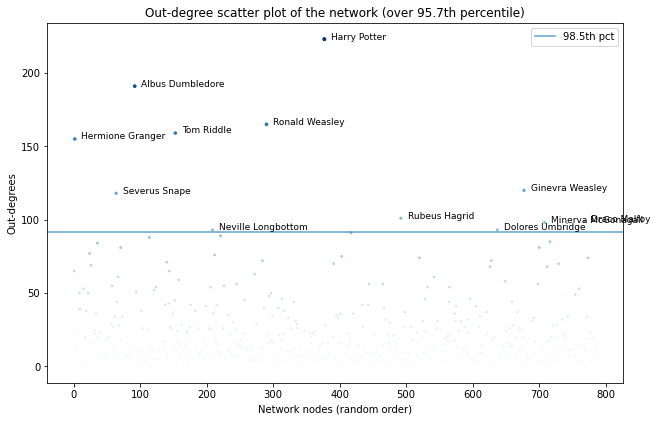

In [111]:
# Investigation of highest out-degree nodes:

plot_scatter_with_labels_over_percentile(out_degrees, 
                                         "Out-degrees", # Axis string
                                         "Out-degree scatter plot of the network (over 95.7th percentile)", # Plot title 
                                         98.5 # percentile
                                        )

_As for the out-degree distribution, Harry Potter is highest. Here, all the highest nodes are individual characters from the universe. Naturally, these WikiPages might have the highest out-degrees because they have had more work done on them than other, smaller pages._

---

### 4. (Unweighted Wiki Digraph) Network other analyses



**Wiki types - What is the distribution of entity types in the Wiki data?**

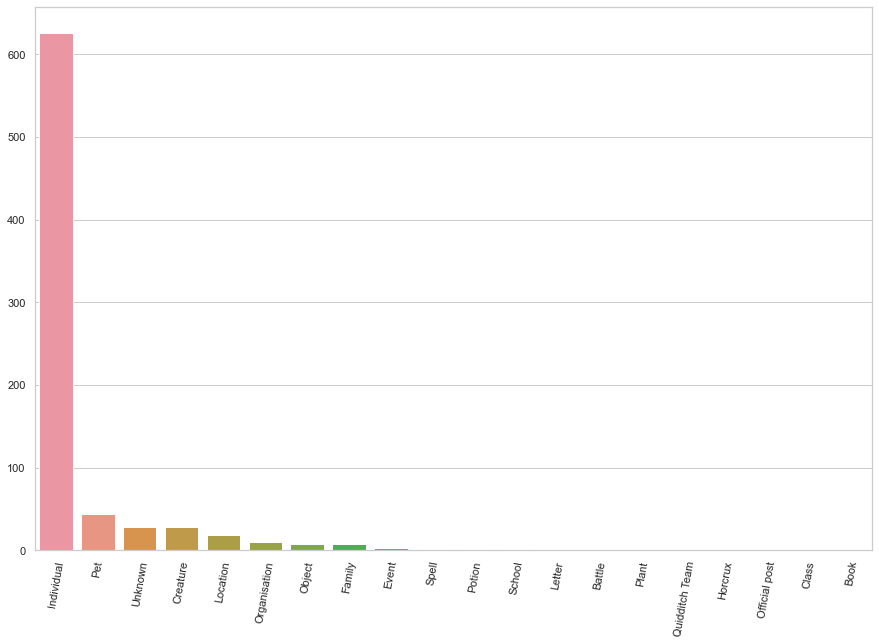

{'Individual': 626, 'Pet': 44, 'Unknown': 28, 'Creature': 28, 'Location': 19, 'Organisation': 10, 'Object': 8, 'Family': 8, 'Event': 3, 'Spell': 2, 'Potion': 2, 'School': 2, 'Letter': 1, 'Battle': 1, 'Plant': 1, 'Quidditch Team': 1, 'Horcrux': 1, 'Official post': 1, 'Class': 1, 'Book': 1}


In [196]:
# Setting style
sns.set_style("whitegrid")

# Getting the types of WikiPages in the network
entity_types = [wiki_type for (node, wiki_type) in G.nodes.data('node_type')]

# Sorting the values by frequency
types = {key: value for key, value in sorted(collections.Counter(entity_types).items(), 
                                             key=lambda item: item[1], reverse=True)}

# Preparing figure
plt.figure(figsize=(15,10))

# Plotting Wiki types
fig = sns.barplot(
    x = list(types.keys()),
    y = list(types.values())
)

plt.xticks(rotation=80)

plt.show()

print(types)


_By far most WikiPages revolve around individuals. Pets and creatures are also popular, but there's some less common types too._

---

# Individuals-only network

### - The basic network above with non-individuals removed


---

### 1. (Individuals-only) Network creation
_We'll copy the basic network above:_

In [127]:
# Fetching the network that was created above

with open('networks/wiki_network_all_wikis.pkl', 'rb') as f:
    G = pickle.load(f)
    
print("Loaded network of type {}, containing {} nodes and {} edges.".format(type(G), len(G), len(G.edges)))

Loaded network of type <class 'networkx.classes.digraph.DiGraph'>, containing 788 nodes and 12386 edges.


**Now, let's determine the nodes that don't represent individuals:**

In [128]:
# Finding all nodes that aren't actual individuals
non_individual_nodes = [node for node in G.nodes if not G.nodes[node]['node_type'] == "Individual"] 

print("Size of entire Wiki network: {}".format(len(G)))

G.remove_nodes_from(non_individual_nodes)

print("Size of Wiki network after deletion of non-individuals: {}".format(len(G)))

Size of entire Wiki network: 788
Size of Wiki network after deletion of non-individuals: 626


In [129]:
# Creating a new folder to store the dataframe and switching to it:
if not os.path.exists("networks"):
    os.mkdir("networks")

# And saving the network:
with open(hd + '/networks/wiki_network_all_individuals.pkl', 'wb') as f:
    pickle.dump(G, f)

---

### 2. (Individuals-Only) Network visualization

In [130]:
# Fetching the network that was created above

with open('networks/wiki_network_all_individuals.pkl', 'rb') as f:
    G = pickle.load(f)
    
print("Loaded network of type {}, containing {} nodes and {} edges.".format(type(G), len(G), len(G.edges)))

Loaded network of type <class 'networkx.classes.digraph.DiGraph'>, containing 626 nodes and 7369 edges.


In [131]:
# There are a lot of characters, so let's only visualise the important ones:

# Constants for minimum in-degrees and out-degrees to be visualized
N_IN = 3
N_OUT = 3

# Finding nodes that don't fit the criteria
lonely_nodes = [node for node in G.nodes if not G.in_degree[node] >= N_IN or not G.out_degree[node] >= N_OUT]

# Taking a copy of the individual network, specifically for visualization
highly_connected_network = G.copy()

# Removing the lowly connected nodes from the visualization network
highly_connected_network.remove_nodes_from(lonely_nodes)

In [132]:
# And defining the GCC to visualize out of this network

print("Network size: " + str(len(highly_connected_network)))

GCC = highly_connected_network.subgraph(max(nx.weakly_connected_components(highly_connected_network)))

print("GCC size: " + str(len(GCC)))

Network size: 313
GCC size: 313


In [133]:
# Determining positions for the individuals

positions = forceatlas2.forceatlas2_networkx_layout(GCC, pos=None, iterations=2000);

In [146]:
# Determining node sizes: 

node_sizes = [val*1500 for val in nx.degree_centrality(GCC).values()] 

# Determining node colours

house_colors = {
		"Gryffindor" : '#740001',
		"Slytherin" : '#1A472A',
		"Ravenclaw" : '#0E1A40',
		"Hufflepuff" : '#FFDB00'
}

grey = '#808080'

# Assigning colours to nodes

node_colors = [house_colors[house] if house in house_colors else grey for (node, house) in GCC.nodes.data('house')]

# Assigning colour to edges

edge_colors = [grey for (u,v) in GCC.edges]

# Let's find the most connected nodes

top_nodes = dict(sorted(nx.degree_centrality(GCC).items(), key = operator.itemgetter(1), reverse = True)[0:10])
top_nodes = list(top_nodes.keys())

# Generate the labels
labels = {}
for node in GCC.nodes():
    if node in top_nodes:
        # Set the node name as the key and the label as its value
        labels[node] = node.split(' ')[0]
        


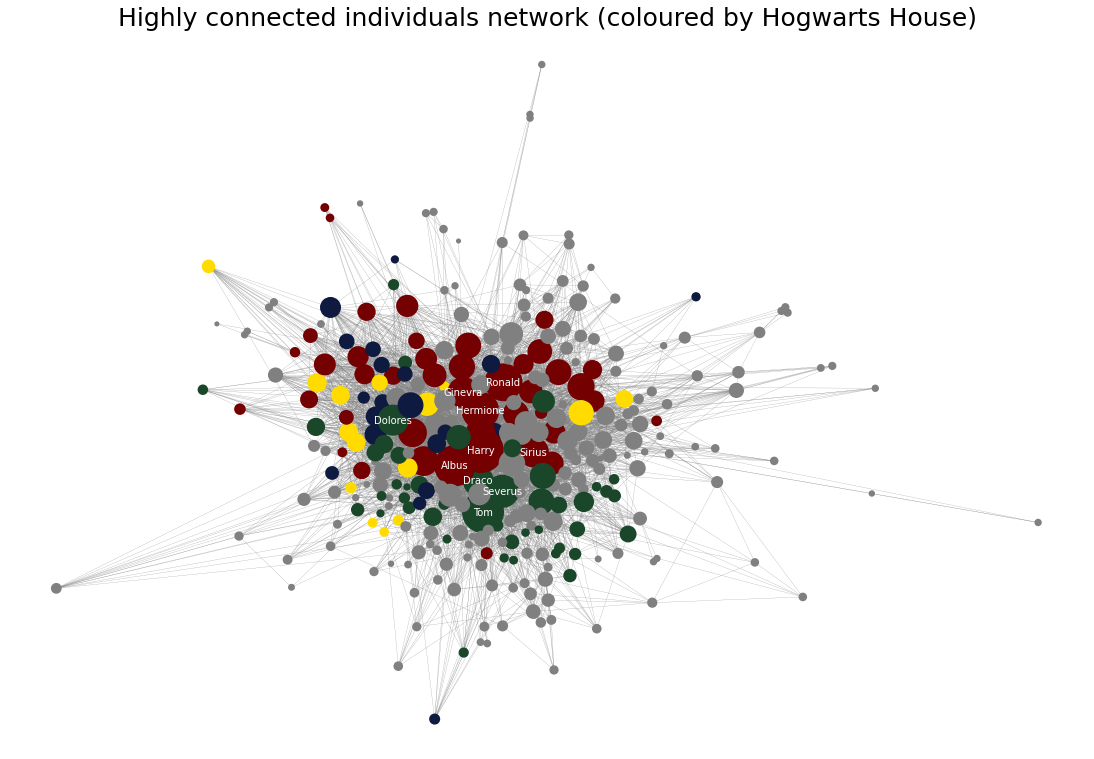

In [147]:
# And we're ready to visualise:

plt.figure(figsize=(15,10))

nx.draw(nx.to_undirected(GCC), 
        positions, 
        with_labels = False, 
        node_size = node_sizes, 
        node_color = node_colors,
        edge_color = edge_colors,
        width=0.2,
        linewidths=2);

# And this time, let's put labels on the most connected nodes:
nx.draw_networkx_labels(GCC, positions, labels, font_size = 10, font_color = 'white');

plt.title("Highly connected individuals network (coloured by Hogwarts House)", fontsize=25, ha='center')
plt.show()

_The figure above shows the highly connected individuals in the network. The grey nodes indicate that the character has no Hogwarts house, while the coloured nodes indicate the house colour of the character._

In [148]:
# Plotting by blood type

blood_colours = {
		'Pure-Blood' : '#173a37',
		'Half-Blood' : '#3f5d6b',
		'Muggle-Born' : '#9283b6',
		'Muggle' : '#f6daa4'
}

grey = '#808080'

# Assigning colours to nodes

node_colors = [blood_colours[blood] if blood in blood_colours else grey for (node, blood) in GCC.nodes.data('blood')]

# Assigning colour to edges

edge_colors = [grey for (u,v) in GCC.edges]

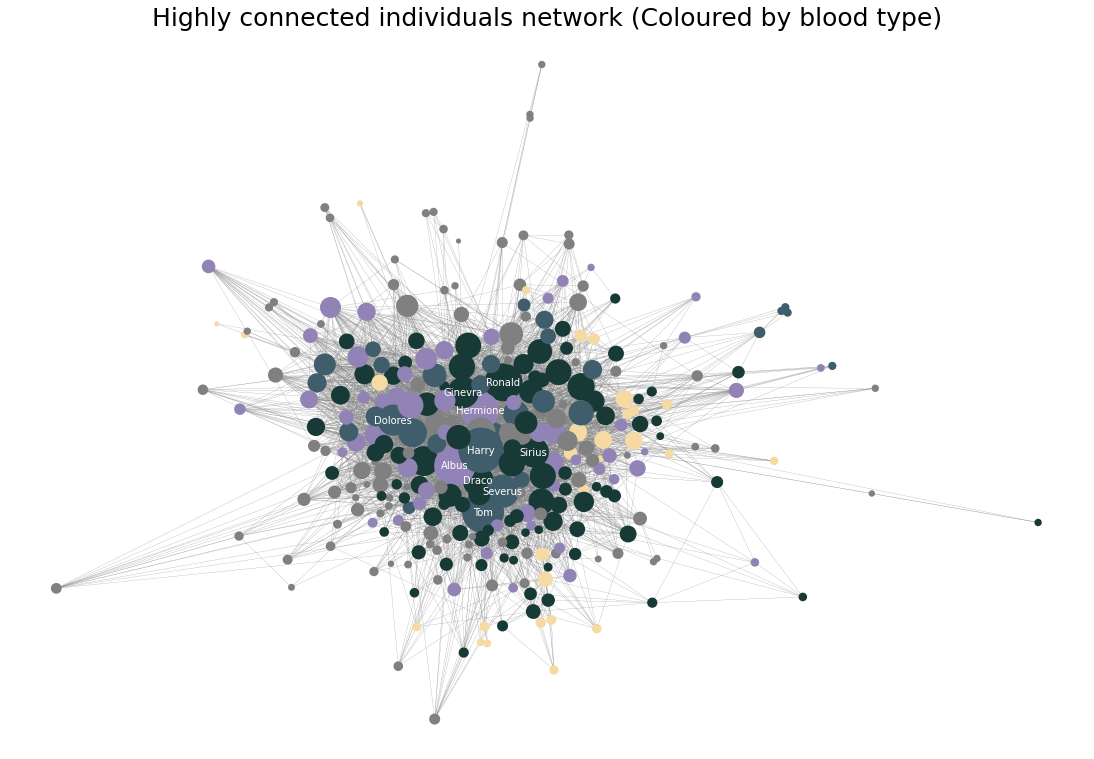

In [149]:
# And we're ready to visualise again:

plt.figure(figsize=(15,10))

nx.draw(nx.to_undirected(GCC), 
        positions, 
        with_labels = False, 
        node_size = node_sizes, 
        node_color = node_colors,
        edge_color = edge_colors,
        width=0.2,
        linewidths=2);

# And this time, let's put labels on the most connected nodes:
nx.draw_networkx_labels(GCC, positions, labels, font_size = 10, font_color = 'white');

plt.title("Highly connected individuals network (Coloured by blood type)", fontsize=25, ha='center')
plt.show()

_The network above shows the same network as before, but now nodes are coloured by Blood type. Beige is Muggle, purple is Muggle-born, blue is Half-blood and dark blue is Pure-blood._

In [152]:
# Plotting by book number

book_colours = {
		1 : '#f8a193',
		2 : '#85ffdd',
		3 : '#2554c7',
		4 : '#a2c7bf',
		5 : '#cc92ba',
		6 : '#8b8991',
		7 : '#8b4516'
}

grey = '#808080'

# Assigning colours to nodes

node_colors = [book_colours[book] if book in book_colours else grey for (node, book) in GCC.nodes.data('book_nr')]

# Assigning colour to edges

edge_colors = [grey for (u,v) in GCC.edges]

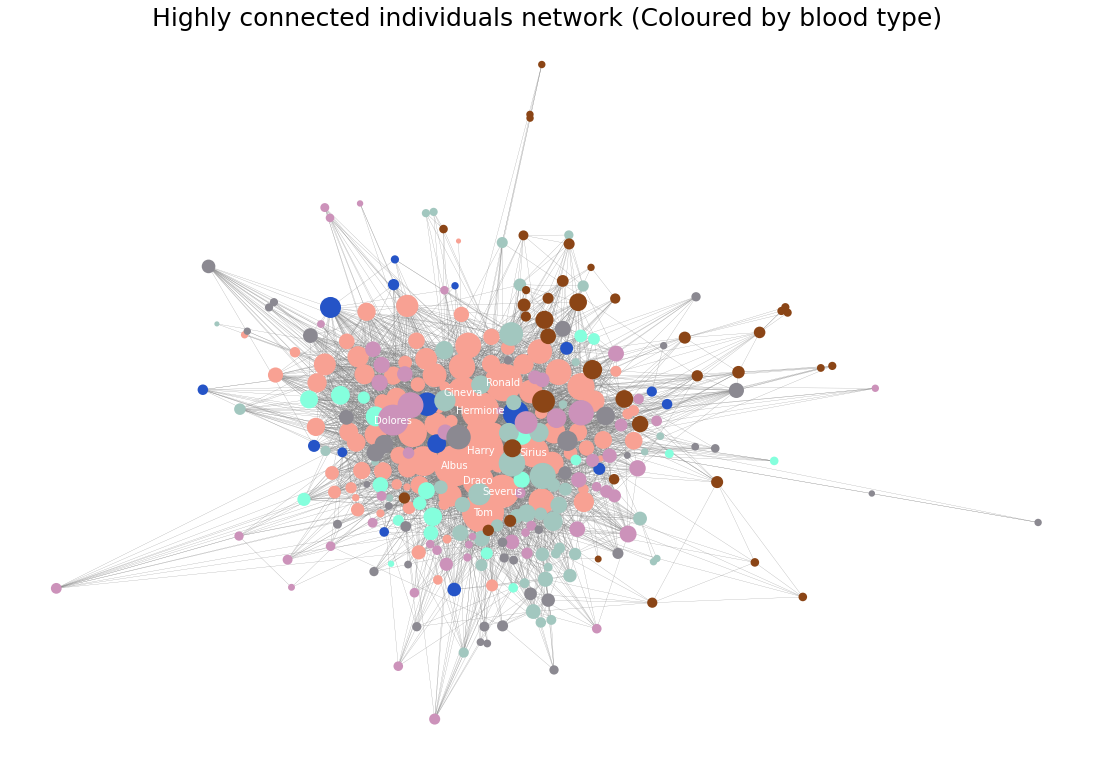

In [153]:
# And we're ready to visualise once again:

plt.figure(figsize=(15,10))

nx.draw(nx.to_undirected(GCC), 
        positions, 
        with_labels = False, 
        node_size = node_sizes, 
        node_color = node_colors,
        edge_color = edge_colors,
        width=0.2,
        linewidths=2);

# And this time, let's put labels on the most connected nodes:
nx.draw_networkx_labels(GCC, positions, labels, font_size = 10, font_color = 'white');

plt.title("Highly connected individuals network (Coloured by book appeared in)", fontsize=25, ha='center')
plt.show()

**Let's visualise this GCC with only individuals with Hogwarts houses:**

In [426]:
# Let's visualise this GCC with only individuals with Hogwarts houses:

houses_only_GCC = GCC.copy()

# Filtering out nodes without houses
nodes_without_houses = [node for node in GCC if G.nodes[node]['house'] == None]

houses_only_GCC.remove_nodes_from(nodes_without_houses)

# Setting house colour
node_colors = [house_colors[house] if house in house_colors else grey for (node, house) in houses_only_GCC.nodes.data('house')]

# Let's find the most connected nodes again
top_nodes = dict(sorted(nx.degree_centrality(houses_only_GCC).items(), key = operator.itemgetter(1), reverse = True)[0:10])
top_nodes = list(top_nodes.keys())

# Generate the labels
labels = {}
for node in houses_only_GCC.nodes():
    if node in top_nodes:
        # Set the node name as the key and the label as its value
        labels[node] = node.split(' ')[0]
        

# Resetting sizes
node_sizes = [val*1500 for val in nx.degree_centrality(houses_only_GCC).values()] 

In [424]:
# positioning nodes

positions = forceatlas2.forceatlas2_networkx_layout(houses_only_GCC, 
                                                    pos=None, 
                                                    iterations=2000);

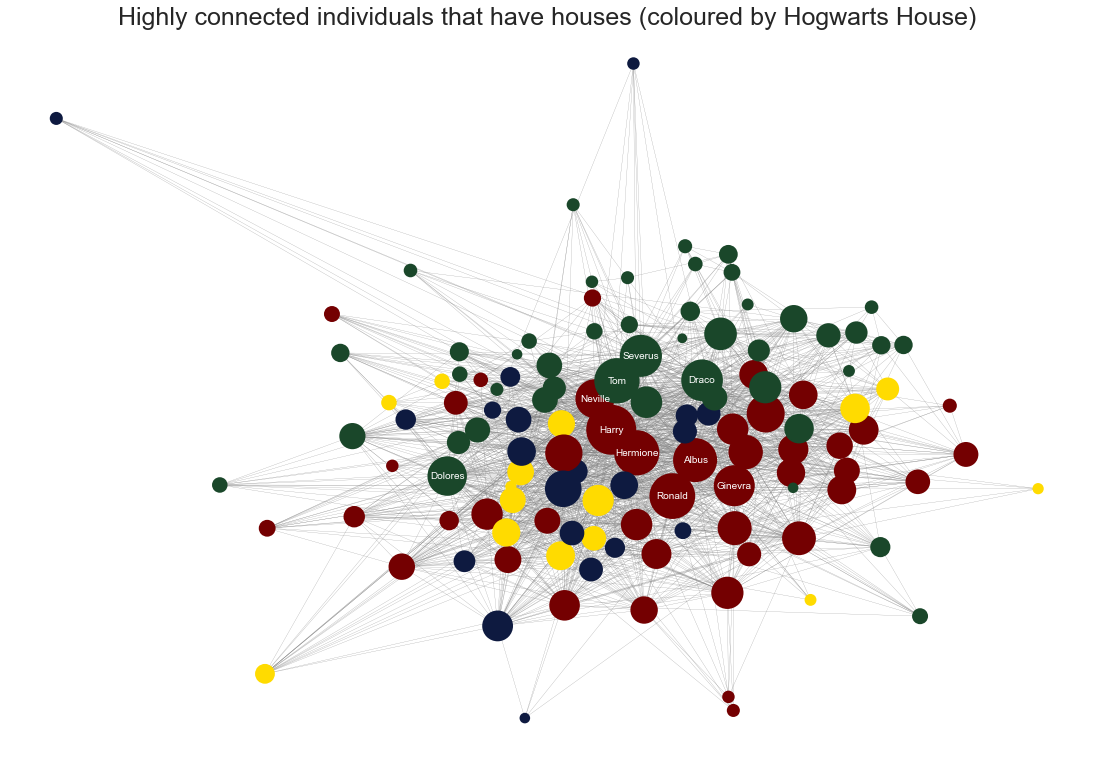

In [425]:
# And we're ready to visualise once again: 

plt.figure(figsize=(15,10))

nx.draw(nx.to_undirected(houses_only_GCC), 
        positions, 
        with_labels = False, 
        node_size = node_sizes, 
        node_color = node_colors,
        edge_color = edge_colors,
        width=0.2,
        linewidths=2);

# And this time, let's put labels on the most connected nodes:
nx.draw_networkx_labels(houses_only_GCC, positions, labels, font_size = 10, font_color = 'white');

plt.title("Highly connected individuals that have houses (coloured by Hogwarts House)", fontsize=25, ha='center')
plt.show()

_It can be seen that the nodes with houses are actually quite sparse compared to the whole Wiki network. Notice how the different houses tend to cluster together._

---

### 3. (Individuals-Only) Network degree analysis
_Let's see which are the highest connected nodes. Note that we're dealing with the whole individuals network here._

In [119]:
# Investigation of highest in-degree and out-degree nodes: 

nodes = [node for node in G.nodes] # for this we need all nodes in network
node_indices = [i for i in range(len(G.nodes))] # indices

random.shuffle(nodes) # randomising the list for ordering (with same seed)

in_degrees = [G.in_degree(node) for node in nodes] # All in-degree values
out_degrees = [G.out_degree(node) for node in nodes] # All out-degree values

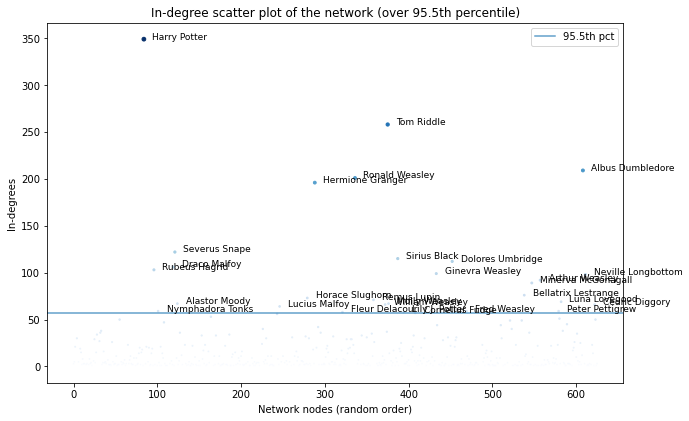

In [120]:
plot_scatter_with_labels_over_percentile(in_degrees, 
                                         "In-degrees", # Axis string
                                         "In-degree scatter plot of the network (over 95.5th percentile)", # Plot title 
                                         95.5 # percentile
                                        )

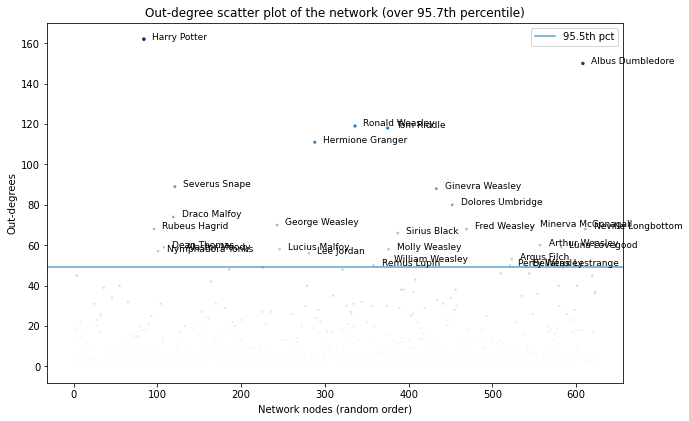

In [121]:
# Investigation of highest out-degree nodes:

plot_scatter_with_labels_over_percentile(out_degrees, 
                                         "Out-degrees", # Axis string
                                         "Out-degree scatter plot of the network (over 95.7th percentile)", # Plot title 
                                         95.5 # percentile
                                        )

### 4. (Individuals-Only) Network other analyses

**Houses stats**

_Let's explore what the distribution of houses is in the Universe:_

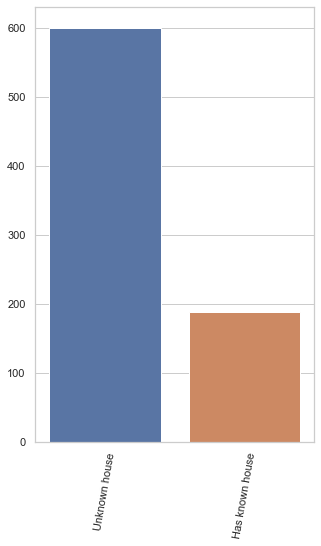

In [250]:
# Getting the houses of the individuals in the network

node_houses = ["Has known house" if house != None else "Unknown house" for (node, house) in G.nodes.data('house')]

# Sorting the values by frequency
types = {key: value for key, value in sorted(collections.Counter(node_houses).items(), 
                                             key=lambda item: item[1], reverse=True)}

# Preparing figure
plt.figure(figsize=(5,8))

# Plotting Wiki types
fig = sns.barplot(
    x = list(types.keys()),
    y = list(types.values())
)

plt.xticks(rotation=80, )

plt.show()

_Unfortunately it seems that most characters do not have registered houses. Let's look at those who do anyway:_

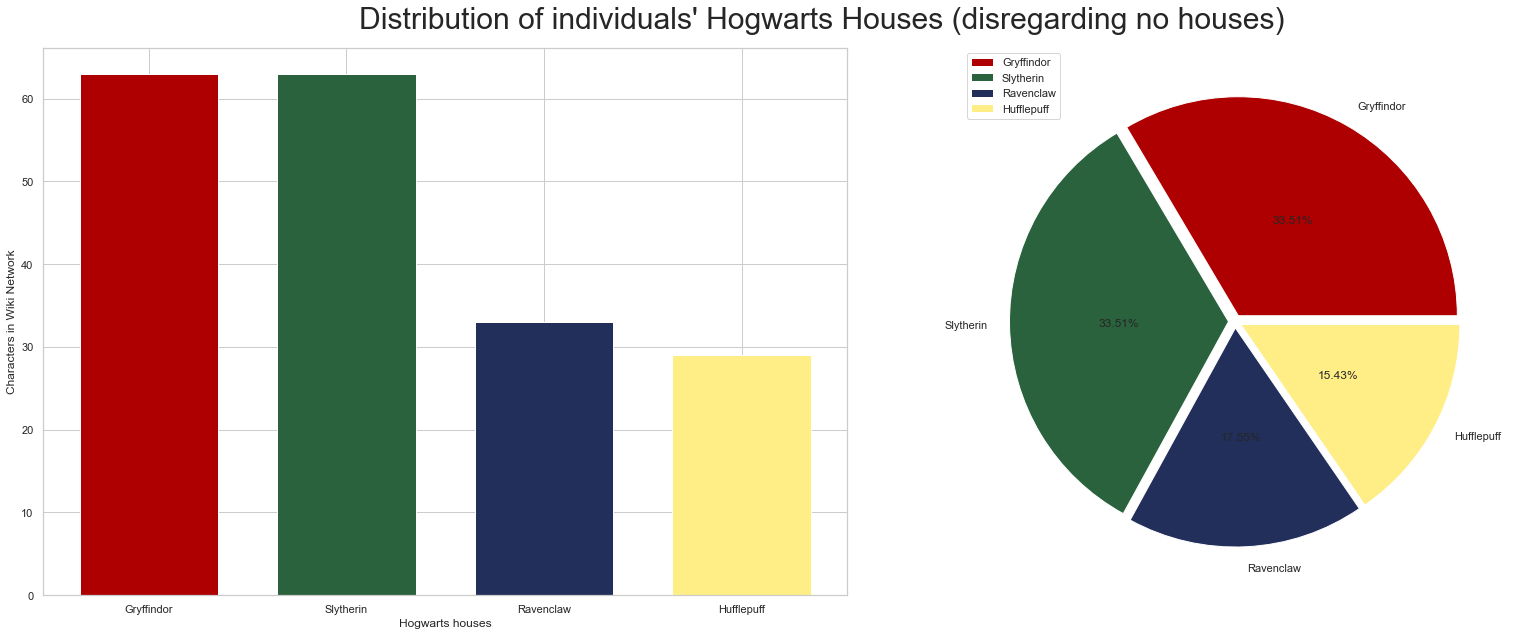

In [289]:
# Setting style
sns.set_style("whitegrid")


# Getting the houses of the individuals in the network
node_houses = [house for (node, house) in G.nodes.data('house')]
node_houses = [house for house in node_houses if house is not None]

# Sorting the values by frequency
types = {key: value for key, value in sorted(collections.Counter(node_houses).items(), 
                                             key=lambda item: item[1], reverse=True)}

houses = list(types.keys())
frequencies = list(types.values())

color_set = ('#AE0001', '#2A623D', '#222F5B', '#FFED86')

labels = houses

fig, axs = plt.subplots(1, 2, figsize=(23, 9))

axs[0].bar(houses, frequencies, color=color_set, width=0.7)
axs[0].set_xlabel("Hogwarts houses")
axs[0].set_ylabel("Characters in Wiki Network")
#axs[0].set_title("Barplot of character's frequency in Hogwarts houses", fontdict = {'fontsize' : 20})

test = {
    "Hello": 55,
    "World": 25
}

# Visualising pie plot
axs[1].pie(x=frequencies, autopct="%.2f%%", explode=[0.03]*4, labels=labels, colors = color_set,  pctdistance=0.5)
#axs[1].set_title("of character's frequency in Hogwarts houses", fontdict = {'fontsize' : 20})
axs[1].legend(loc='upper left')
plt.suptitle("Distribution of individuals' Hogwarts Houses (disregarding no houses)", size=30)
fig.tight_layout()


_It would appear that Gryffindor and Slytherin are noticably more common in the Wiki universe. They're also precisely as common, a real battle of Good and Evil!_

---

**Blood types**

_Now let's explore what the distribution of blood types is in the Universe:_

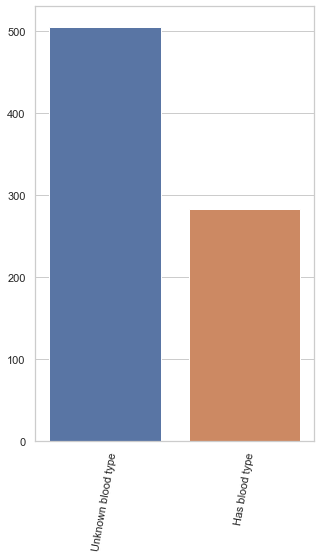

In [292]:
# Getting the blood types of the individuals in the network

blood_types = ["Has blood type" if blood_type != "Unknown" else "Unknown blood type" for (node, blood_type) in G.nodes.data('blood')]

# Sorting the values by frequency
types = {key: value for key, value in sorted(collections.Counter(blood_types).items(), 
                                             key=lambda item: item[1], reverse=True)}

# Preparing figure
plt.figure(figsize=(5,8))

# Plotting Wiki types
fig = sns.barplot(
    x = list(types.keys()),
    y = list(types.values())
)

plt.xticks(rotation=80, )

plt.show()

_Unfortunately, it seems like there's a lot of missing data on blood types again. But we have almost 300 individuals with a noted blood type (or several, but that has been cleaned). Let's see the distribution:_

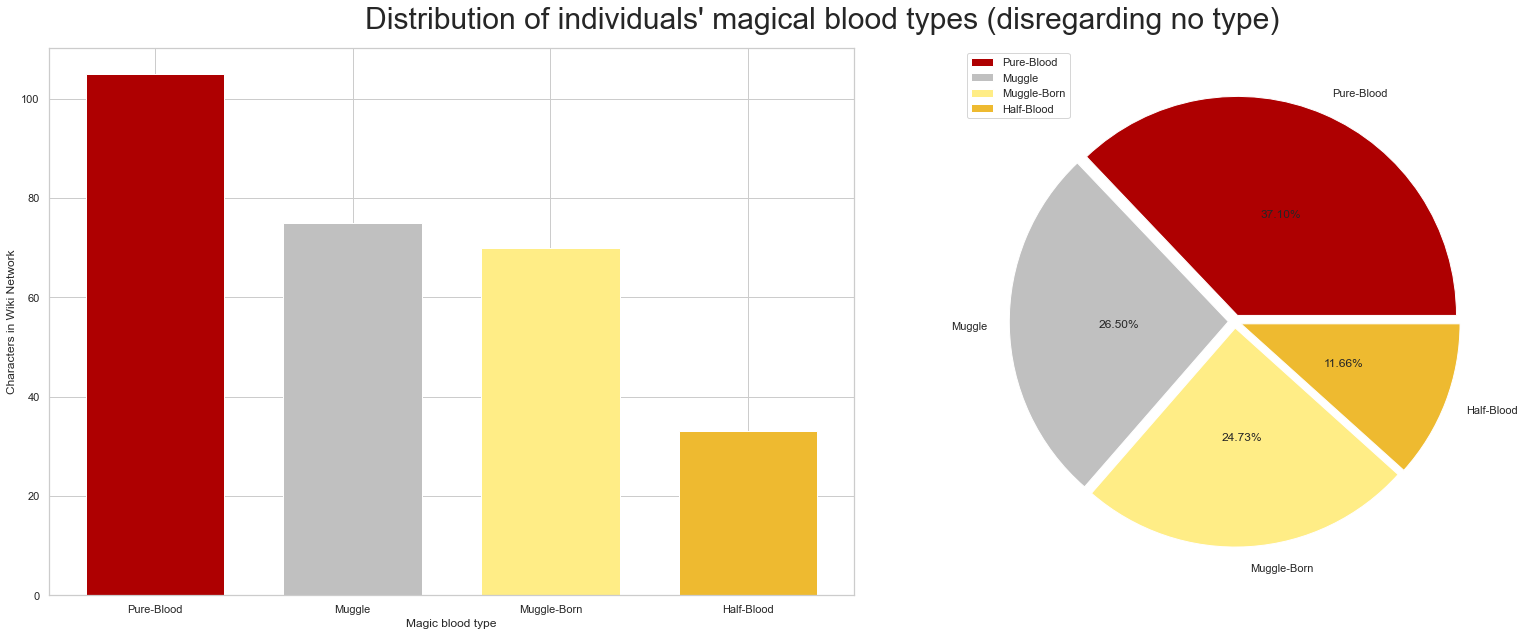

In [335]:
# Setting style
sns.set_style("whitegrid")

blood_types = ["Has blood type" if blood_type != "Unknown" else "Unknown blood type" for (node, blood_type) in G.nodes.data('blood')]

# Getting the blood types of the individuals in the network
node_blood_types = [blood_type for (node, blood_type) in G.nodes.data('blood')]
node_blood_types = [blood_type for blood_type in node_blood_types if blood_type != "Unknown"]

# Sorting the values by frequency
types = {key: value for key, value in sorted(collections.Counter(node_blood_types).items(), 
                                             key=lambda item: item[1], reverse=True)}
blood_types = list(types.keys())
frequencies = list(types.values())

color_set = ('#AE0001', '#C0C0C0', '#FFED86', '#EEBA30')

labels = blood_types

fig, axs = plt.subplots(1, 2, figsize=(23, 9))

axs[0].bar(blood_types, frequencies, color=color_set, width=0.7)
axs[0].set_xlabel("Magic blood type")
axs[0].set_ylabel("Characters in Wiki Network")
#axs[0].set_title("Barplot of character's frequency in Hogwarts houses", fontdict = {'fontsize' : 20})

# Visualising pie plot
axs[1].pie(x=frequencies, autopct="%.2f%%", explode=[0.03]*4, labels=labels, colors = color_set,  pctdistance=0.5)
#axs[1].set_title("of character's frequency in Hogwarts houses", fontdict = {'fontsize' : 20})
axs[1].legend(loc='upper left')
plt.suptitle("Distribution of individuals' magical blood types (disregarding no type)", size=30)
fig.tight_layout()


_The Harry Potter universe seems to be mostly populated by pure-blood witches and wizards. Muggles and Muggle-born are also common, with half-bloods being least common._

---

**Hogwarts houses with by blood type**

In [362]:
# Fetching nodes that have a valid blood type
blood_type_nodes = [node if blood_type != "Unknown" else None for (node, blood_type) in G.nodes.data('blood')]

# Fetching nodes that have a valid house
house_nodes = [node if house != None else None for (node, house) in G.nodes.data('house')]

# Intersecting the two
blood_types_and_houses =  list(set(blood_type_nodes) & set(house_nodes))

print(houses)
print(blood_types)

# Declaring a dict to store the data
houses_by_blood_type = {
    "Pure-Blood": [0, 0, 0, 0],
    "Muggle": [0, 0, 0, 0],
    "Muggle-Born": [0, 0, 0, 0],
    "Half-Blood": [0, 0, 0, 0]
}

for i in range(len(houses)):
    curr_house = houses[i]
    for node in blood_types_and_houses: # looping through the nodes we know both have a house and blood type
        if node: # bug fix
            nd = G.nodes[node]
            if (nd['house']  == curr_house):
                blood_type = nd['blood']
                houses_by_blood_type[blood_type][i] += 1 # Setting blood type's house index to +1

['Gryffindor', 'Slytherin', 'Ravenclaw', 'Hufflepuff']
['Pure-Blood', 'Muggle', 'Muggle-Born', 'Half-Blood']


In [363]:
print(houses_by_blood_type)

{'Pure-Blood': [16, 34, 2, 4], 'Muggle': [1, 4, 0, 3], 'Muggle-Born': [14, 5, 11, 6], 'Half-Blood': [8, 5, 7, 3]}


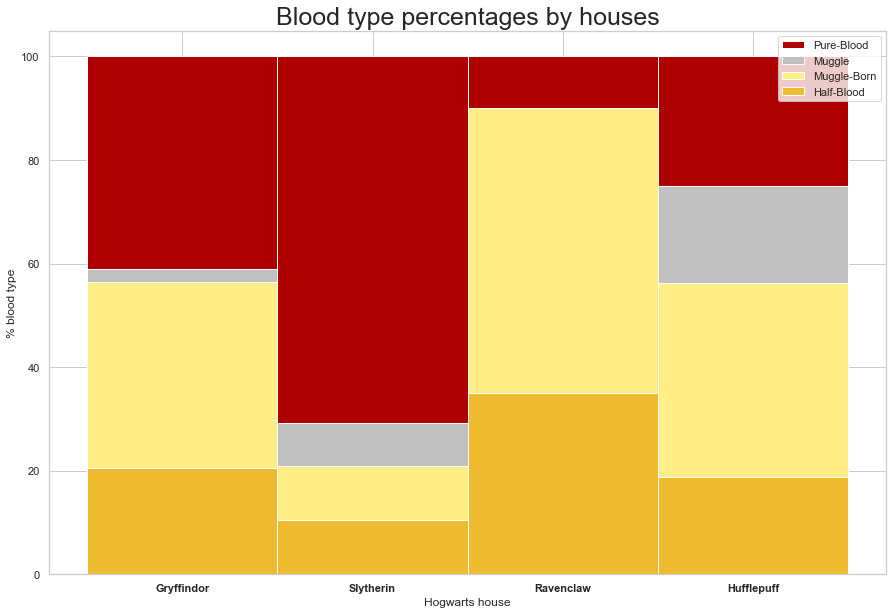

In [402]:
plt.figure(figsize=(15,10))

# Defining same colour set as before for blood types
color_set = ('#AE0001', '#C0C0C0', '#FFED86', '#EEBA30')

# Setting the positions for the bars
x_positions = list(range(len(houses_by_blood_type)))

# Getting the values for the houses for each blood type
pure_bloods = np.array(houses_by_blood_type['Pure-Blood'])
muggles = np.array(houses_by_blood_type['Muggle'])
muggle_born = np.array(houses_by_blood_type['Muggle-Born'])
half_bloods = np.array(houses_by_blood_type['Half-Blood'])

# Adding the arrays up to get the total amount of individuals by house
tot_individuals = pure_bloods + muggles + muggle_born + half_bloods

# Getting the percentages
pure_bloods = pure_bloods / tot_individuals * 100
muggles = muggles / tot_individuals * 100
muggle_born = muggle_born / tot_individuals * 100
half_bloods = half_bloods / tot_individuals * 100

# Plotting the actual bars
ax0 = plt.bar(x_positions, pure_bloods, bottom = muggles + muggle_born + half_bloods, edgecolor="White", width=1, label='Pure-Blood', color = color_set[0])
ax1 = plt.bar(x_positions, muggles, bottom = muggle_born + half_bloods, edgecolor="White", width=1, label='Muggle', color = color_set[1])
ax2 = plt.bar(x_positions, muggle_born, bottom = half_bloods, edgecolor="White", width=1, label='Muggle-Born', color = color_set[2])
ax3 = plt.bar(x_positions, half_bloods, edgecolor="White", width=1, label='Half-Blood', color = color_set[3])

# Setting plot details
plt.xticks(x_positions, houses, fontweight='bold')
plt.xlabel("Hogwarts house")
plt.ylabel("% blood type")
plt.legend()
plt.title("Blood type percentages by houses", size = 25)

plt.show()

_It appears that Slytherin is indeed the place to be for pure-bloods._

In [403]:
# WHY ARE THERE MUGGLES WITH HOUSES THO?

---

# Family and loyalty network

### - Network with links from loyalty and family ties only


---

### 1. (Family and loyalty) Network creation
_Let's find these new edges:_

In [492]:
DG_Fam = nx.DiGraph()

# Add all the edges to the graph
for idx, row in df_wiki.iterrows():
    DG_Fam.add_node(row.wiki, 
                book_nr = row.book, 
                house = row.house, 
                node_type = row.type, 
                links = row.links, 
                wiki_text = row.text,
                job = row.job,
                blood = row.blood,
                family = row.family,
                loyalties = row.loyalties
               )
        
print("Added {} nodes. Size of network: {}".format(len(df_wiki), len(DG_Fam))) 

Added 788 nodes. Size of network: 788


In [493]:
# And adding the edges:

for idx, row in df_wiki[pd.notna(df_wiki.links)].iterrows():
    if row['family']:
        for link in row['family']:
            if link in DG_Fam: # If other character is in the network
                DG_Fam.add_edge(row.wiki, link)
    if row['loyalties']:
        for link in row['loyalties']:
            if link in DG_Fam:
                DG_Fam.add_edge(row.wiki, link)
            
print("{} edges in network.".format(len(DG_Fam.edges)))

1512 edges in network.


In [494]:
# Creating a new folder to store the dataframe and switching to it:
if not os.path.exists("networks"):
    os.mkdir("networks")

# And saving the network:
with open(hd + '/networks/wiki_network_family_and_loyalties.pkl', 'wb') as f:
    pickle.dump(DG_Fam, f)

---

### 2. (Family and loyalty) Network visualization

In [495]:
# Fetching the network that was created above

with open('networks/wiki_network_family_and_loyalties.pkl', 'rb') as f:
    G = pickle.load(f)
    
print("Loaded network of type {}, containing {} nodes and {} edges.".format(type(G), len(G), len(G.edges)))

Loaded network of type <class 'networkx.classes.digraph.DiGraph'>, containing 788 nodes and 1512 edges.


In [496]:
# Constants for minimum in-degrees and out-degrees to be visualized
N_IN = 1
N_OUT = 1

# Finding nodes that don't fit the criteria
lonely_nodes = [node for node in G.nodes if not G.in_degree[node] >= N_IN or not G.out_degree[node] >= N_OUT]

G.remove_nodes_from(lonely_nodes)

print("Size of network after isolation: " + str(len(G)))

Size of network after isolation: 254


In [498]:
GCC = G.subgraph(max(nx.weakly_connected_components(G)))
print(len(GCC))

137


In [482]:
# Determining positions for the individuals

positions = forceatlas2.forceatlas2_networkx_layout(GCC, pos=None, iterations=2000);

In [499]:
# Determining node sizes: 

node_sizes = [val*1500 for val in nx.degree_centrality(GCC).values()] 

# Determining node colours

house_colors = {
		"Gryffindor" : '#740001',
		"Slytherin" : '#1A472A',
		"Ravenclaw" : '#0E1A40',
		"Hufflepuff" : '#FFDB00'
}

grey = '#808080'

# Assigning colours to nodes

node_colors = [house_colors[house] if house in house_colors else grey for (node, house) in GCC.nodes.data('house')]

# Assigning colour to edges

edge_colors = [grey for (u,v) in GCC.edges]

# Let's find the most connected nodes

top_nodes = dict(sorted(nx.degree_centrality(GCC).items(), key = operator.itemgetter(1), reverse = True)[0:10])
top_nodes = list(top_nodes.keys())

# Generate the labels
labels = {}
for node in GCC.nodes():
    if node in top_nodes:
        # Set the node name as the key and the label as its value
        labels[node] = node.split(' ')[0]
        

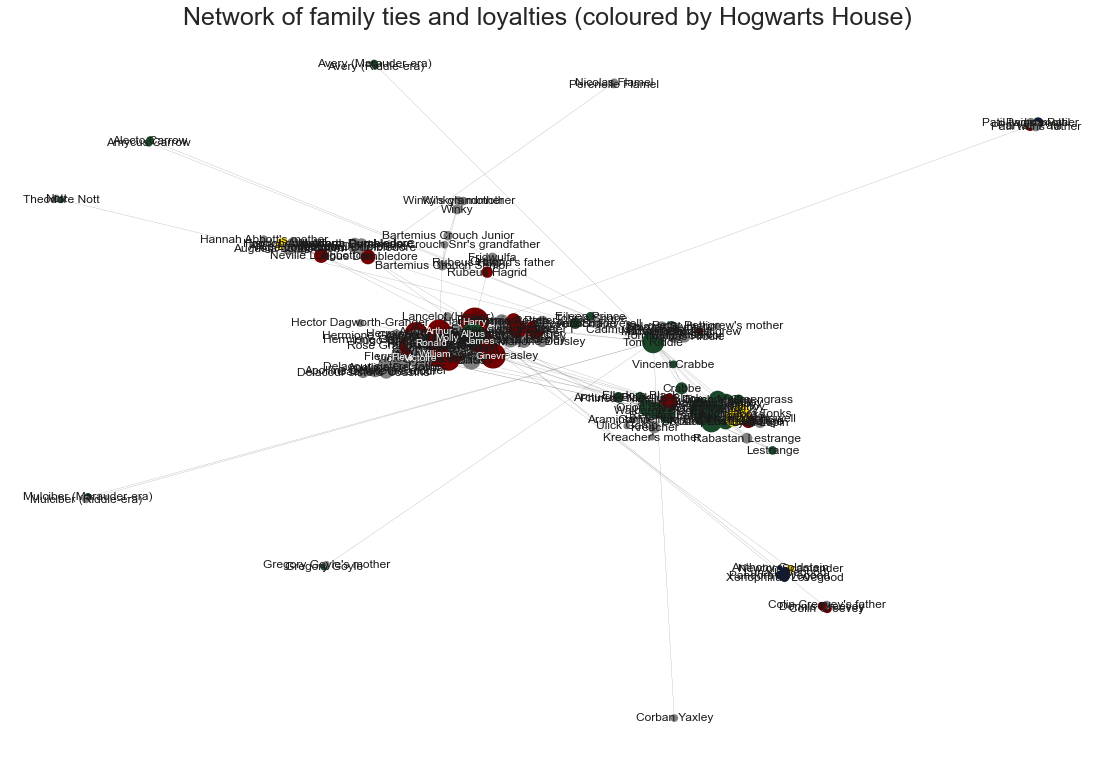

In [501]:
# And we're ready to visualise once again: 

plt.figure(figsize=(15,10))

nx.draw(nx.to_undirected(GCC), 
        positions, 
        with_labels = True, 
        node_size = node_sizes, 
        node_color = node_colors,
        edge_color = edge_colors,
        width=0.2,
        linewidths=2);

# And this time, let's put labels on the most connected nodes:
nx.draw_networkx_labels(GCC, positions, labels, font_size = 10, font_color = 'white');

plt.title("Network of family ties and loyalties (coloured by Hogwarts House)", fontsize=25, ha='center')
plt.show()

---

---

---

---

---

---

---

---

---

---

---

---

---

---

---

---

---

---

---

---

---

---

---

---